In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import datetime
import os

In [23]:
sales_data = pd.read_csv(os.path.join('./Data Sets/', 'train.csv'))
sales_data.head()

/tmp/ipykernel_928793/3917828530.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv(os.path.join('./Data Sets/', 'train.csv'))


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [24]:
sales_data.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [25]:
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

In [26]:
sales_data.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [27]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


## Data Description:
- Id: transaction ID (combination of Store and date) 
- Store: unique store Id
- Sales: sales/day, this is the target variable 
- Customers: number of customers on a given day
- Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
- Promo: describes if store is running a promo on that day or not
- StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

In [28]:
## Lets load the second data based on stores
store_data = pd.read_csv(os.path.join('./Data Sets/', 'store.csv'))
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [29]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [30]:
store_data.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

## Data Description:
- StoreType: categorical variable to indicate type of store (a, b, c, d)
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance (meters): distance to closest competitor store
- CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
- Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
- Promo2Since [Year/Week]: date when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


## TIME FOR SOME EDA

In [31]:
sales_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [32]:
sales_data['StateHoliday'] = sales_data['StateHoliday'].replace(0, '0')

In [33]:
sales_data['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

### One of the important things is whether or not, stores are open during holidays. 
So lets plot to see the counts in each of the stateholidays with open or closed

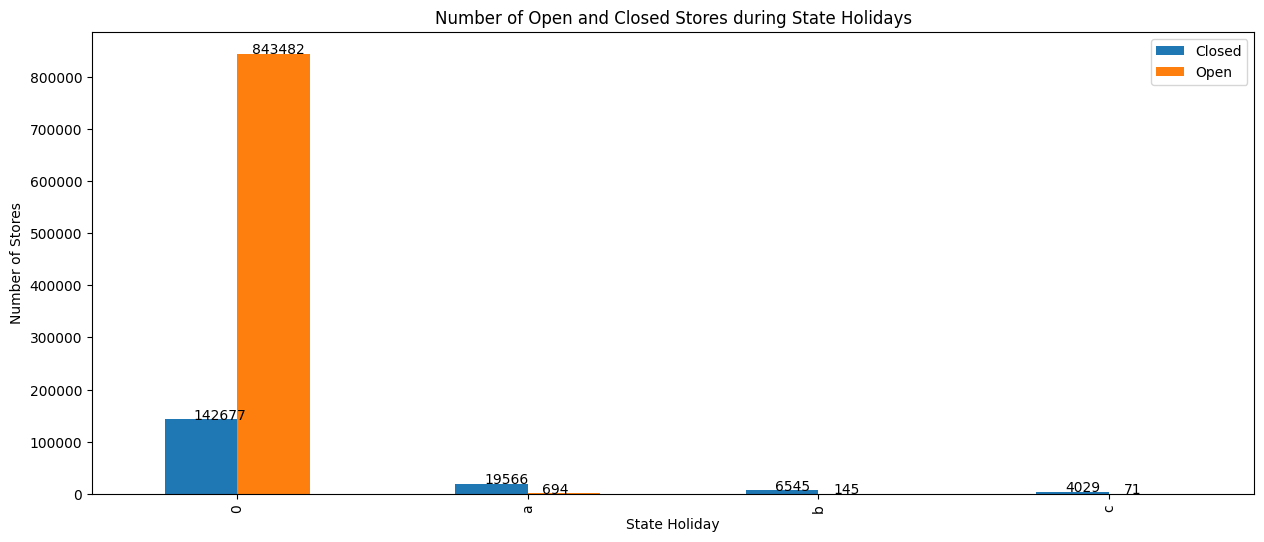

In [49]:
grouped_df = sales_data.groupby(['StateHoliday', 'Open'])['Store'].count().unstack()
grouped_df.plot(kind='bar', stacked=False, figsize=(15, 6))
plt.xlabel('State Holiday')
plt.ylabel('Number of Stores')
plt.title('Number of Open and Closed Stores during State Holidays')
plt.legend( labels=['Closed', 'Open'], loc='upper right')
for i in range(len(grouped_df.index)):
    closed_count = grouped_df.iloc[i,0]
    open_count = grouped_df.iloc[i,1]
    plt.text(i-0.15, closed_count+100, str(closed_count), color='black')
    plt.text(i+0.05, open_count+100, str(open_count), color='black')
plt.show()

In [52]:
sales_data['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [55]:
sales_data['Store'].describe()

count    1.017209e+06
mean     5.584297e+02
std      3.219087e+02
min      1.000000e+00
25%      2.800000e+02
50%      5.580000e+02
75%      8.380000e+02
max      1.115000e+03
Name: Store, dtype: float64

In [57]:
max_sales_by_store = sales_data.groupby('Store')['Sales'].max()

In [58]:
max_sales_by_store[1]

9528

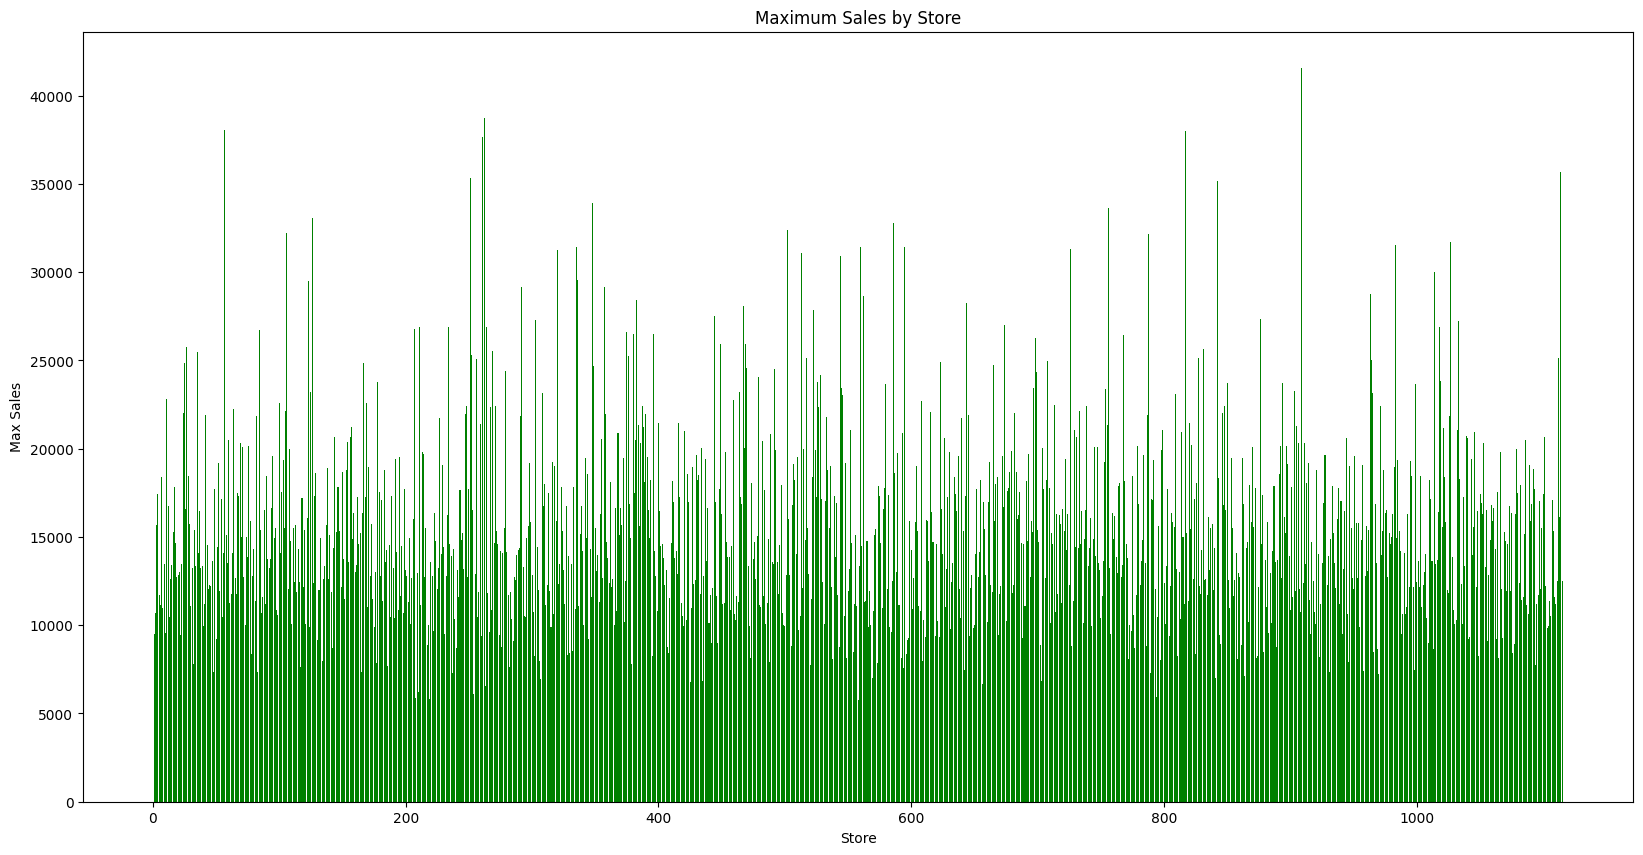

In [59]:
plt.figure(figsize=(20, 10))  # Set the figure size
plt.bar(max_sales_by_store.index, max_sales_by_store.values, color = 'Green')  # Create a bar plot
plt.xlabel('Store')  # Set the x-axis label
plt.ylabel('Max Sales')  # Set the y-axis label
plt.title('Maximum Sales by Store')  # Set the plot title
plt.show()

In [60]:
## Null values
sales_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [61]:
sales_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

array([[<AxesSubplot: title={'center': 'DayOfWeek'}>,
        <AxesSubplot: title={'center': 'Date'}>,
        <AxesSubplot: title={'center': 'Sales'}>],
       [<AxesSubplot: title={'center': 'Customers'}>,
        <AxesSubplot: title={'center': 'Open'}>,
        <AxesSubplot: title={'center': 'Promo'}>],
       [<AxesSubplot: title={'center': 'SchoolHoliday'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

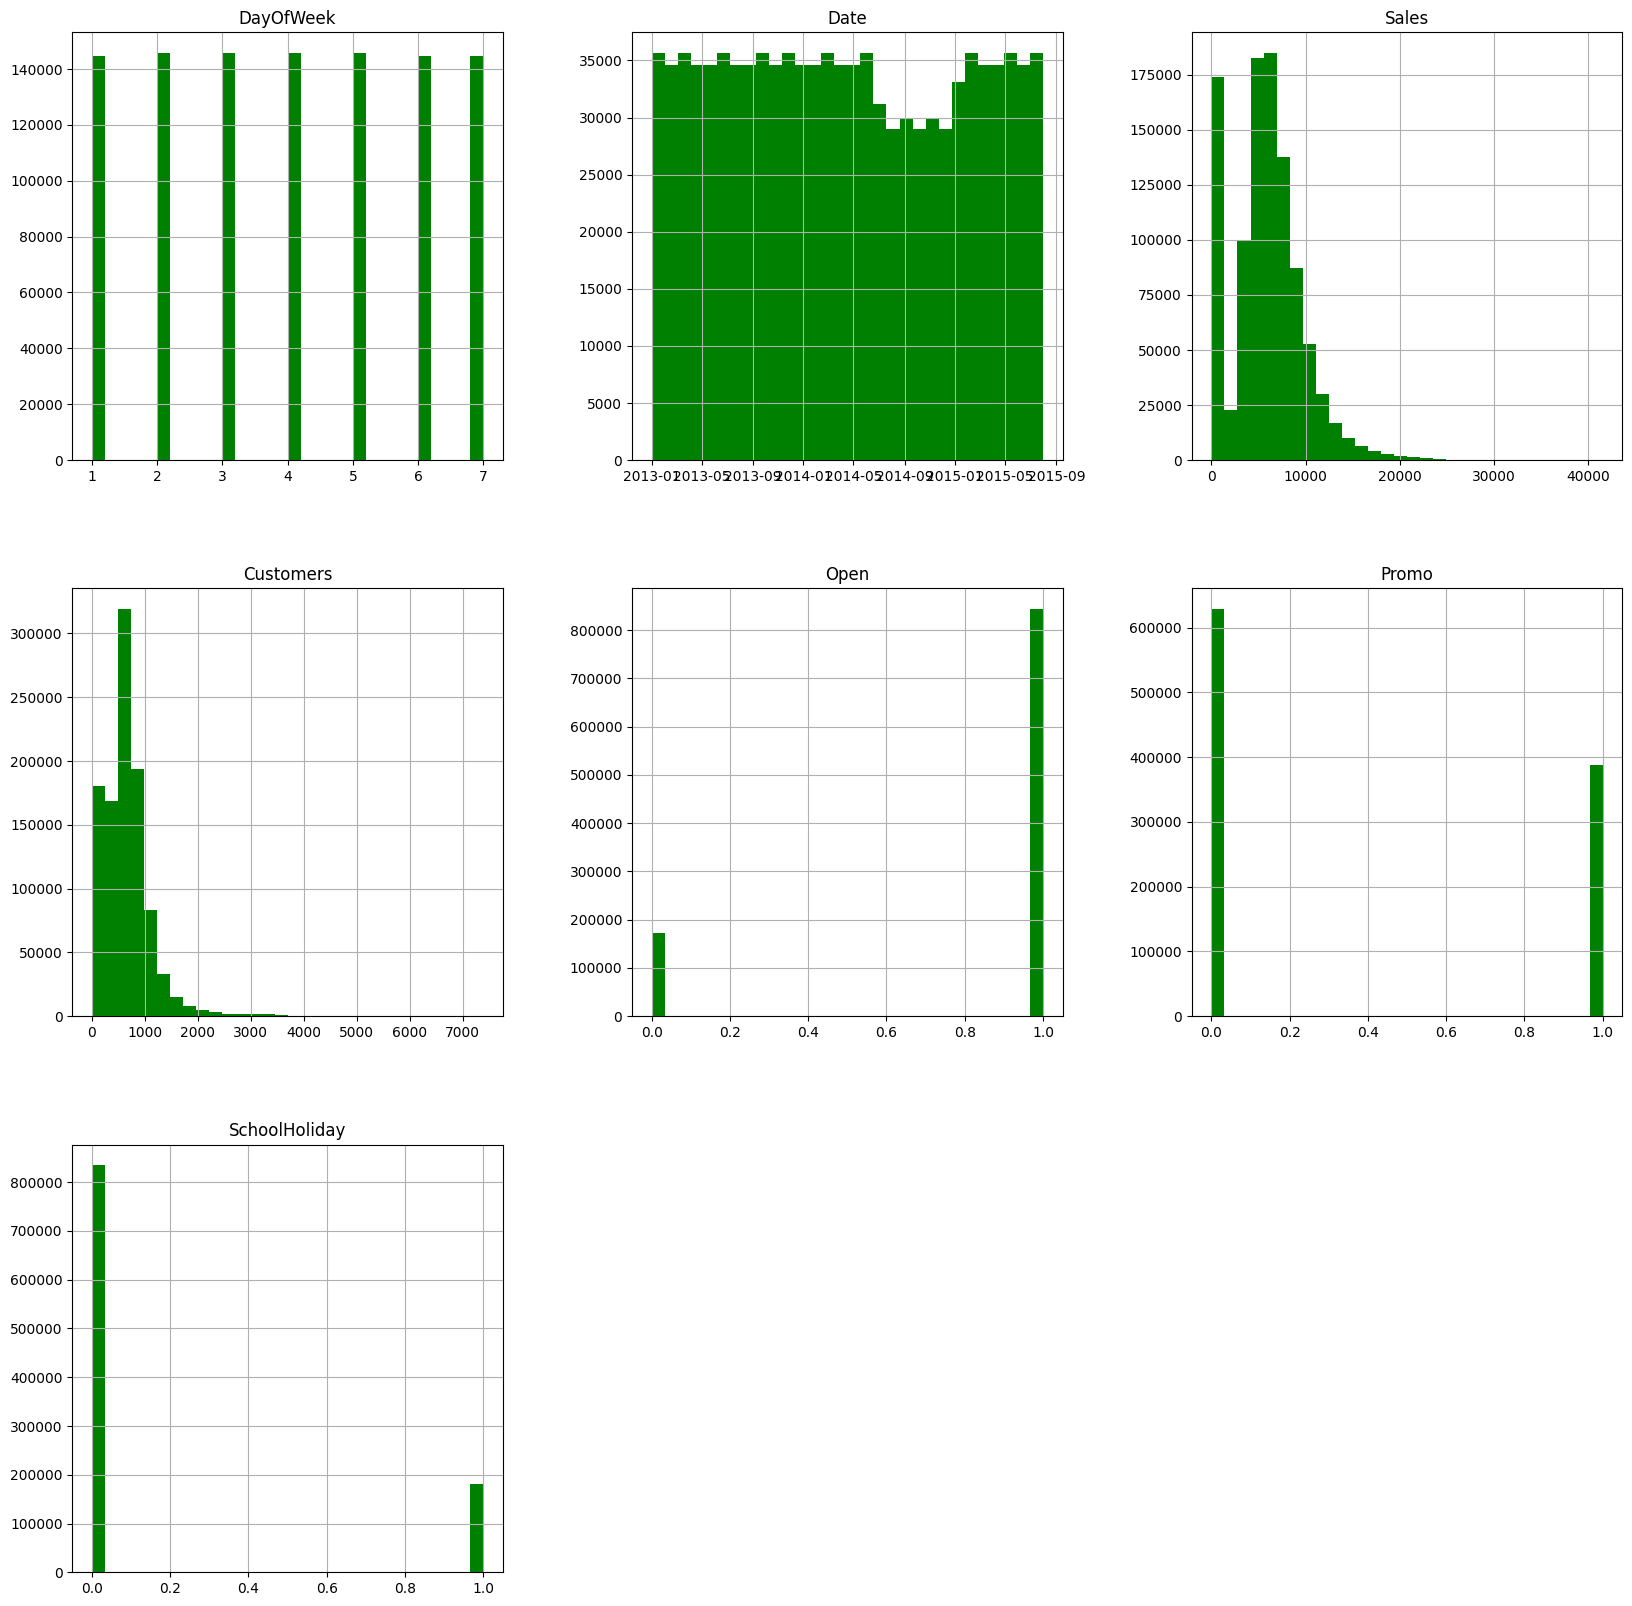

In [62]:
sales_data[['DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday']].hist(bins = 30, figsize = (20,20), color = 'g')

In [63]:
closed_train_df = sales_data[sales_data['Open'] == 0]
open_train_df   = sales_data[sales_data['Open'] == 1]

open_counts = open_train_df['Open'].value_counts()
closed_counts = closed_train_df['Open'].value_counts()

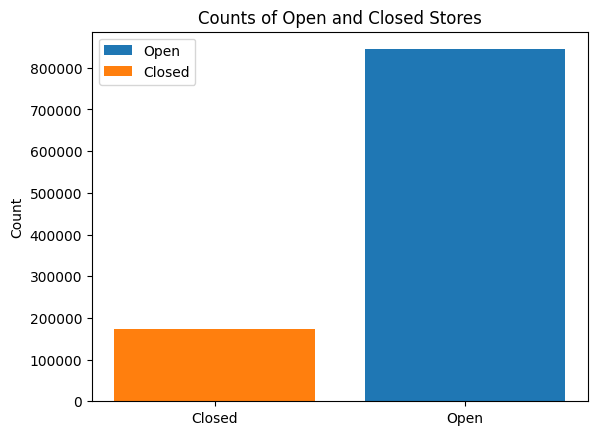

In [64]:
fig, ax = plt.subplots()
ax.bar(open_counts.index, open_counts.values, label='Open')
ax.bar(closed_counts.index, closed_counts.values, label='Closed')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Closed', 'Open'])
ax.set_ylabel('Count')
ax.set_title('Counts of Open and Closed Stores')
ax.legend()
plt.show()

In [65]:
print("Total =", len(sales_data))
print("Number of closed stores =", len(closed_train_df))
print("Number of open stores =", len(open_train_df))

Total = 1017209
Number of closed stores = 172817
Number of open stores = 844392


In [66]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
sales_data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000
mean,558.42973,3.99834,5773.81897,633.14595,0.83011,0.38151,0.17865
std,321.90865,1.99739,3849.92618,464.41173,0.37554,0.48576,0.38306
min,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,280.00000,2.00000,3727.00000,405.00000,1.00000,0.00000,0.00000
50%,558.00000,4.00000,5744.00000,609.00000,1.00000,0.00000,0.00000
75%,838.00000,6.00000,7856.00000,837.00000,1.00000,1.00000,0.00000
max,1115.00000,7.00000,41551.00000,7388.00000,1.00000,1.00000,1.00000


In [67]:
## Second dataset
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [68]:
store_data[store_data['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.00000,2013.00000,"Feb,May,Aug,Nov"


In [69]:
store_data[store_data['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.00000,NaN,NaN,1,13.00000,2010.00000,"Jan,Apr,Jul,Oct"
12,13,d,a,310.00000,NaN,NaN,1,45.00000,2009.00000,"Feb,May,Aug,Nov"
15,16,a,c,3270.00000,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.00000,NaN,NaN,1,22.00000,2011.00000,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.00000,NaN,NaN,1,22.00000,2012.00000,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.00000,NaN,NaN,1,10.00000,2014.00000,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.00000,NaN,NaN,1,14.00000,2011.00000,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.00000,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.00000,NaN,NaN,0,NaN,NaN,NaN


In [70]:
store_data[ store_data['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00000,9.00000,2008.00000,0,NaN,NaN,NaN
3,4,c,c,620.00000,9.00000,2009.00000,0,NaN,NaN,NaN
4,5,a,a,29910.00000,4.00000,2015.00000,0,NaN,NaN,NaN
5,6,a,a,310.00000,12.00000,2013.00000,0,NaN,NaN,NaN
6,7,a,c,24000.00000,4.00000,2013.00000,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.00000,4.00000,2004.00000,0,NaN,NaN,NaN
1109,1110,c,c,900.00000,9.00000,2010.00000,0,NaN,NaN,NaN
1111,1112,c,c,1880.00000,4.00000,2006.00000,0,NaN,NaN,NaN
1112,1113,a,c,9260.00000,NaN,NaN,0,NaN,NaN,NaN


In [71]:
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionDistance']
for str in str_cols:
    store_data [str].fillna(0, inplace = True)

In [72]:
store_data.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [73]:
store_data.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

array([[<AxesSubplot: title={'center': 'CompetitionDistance'}>,
        <AxesSubplot: title={'center': 'CompetitionOpenSinceMonth'}>],
       [<AxesSubplot: title={'center': 'CompetitionOpenSinceYear'}>,
        <AxesSubplot: title={'center': 'Promo2'}>],
       [<AxesSubplot: title={'center': 'Promo2SinceWeek'}>,
        <AxesSubplot: title={'center': 'Promo2SinceYear'}>]], dtype=object)

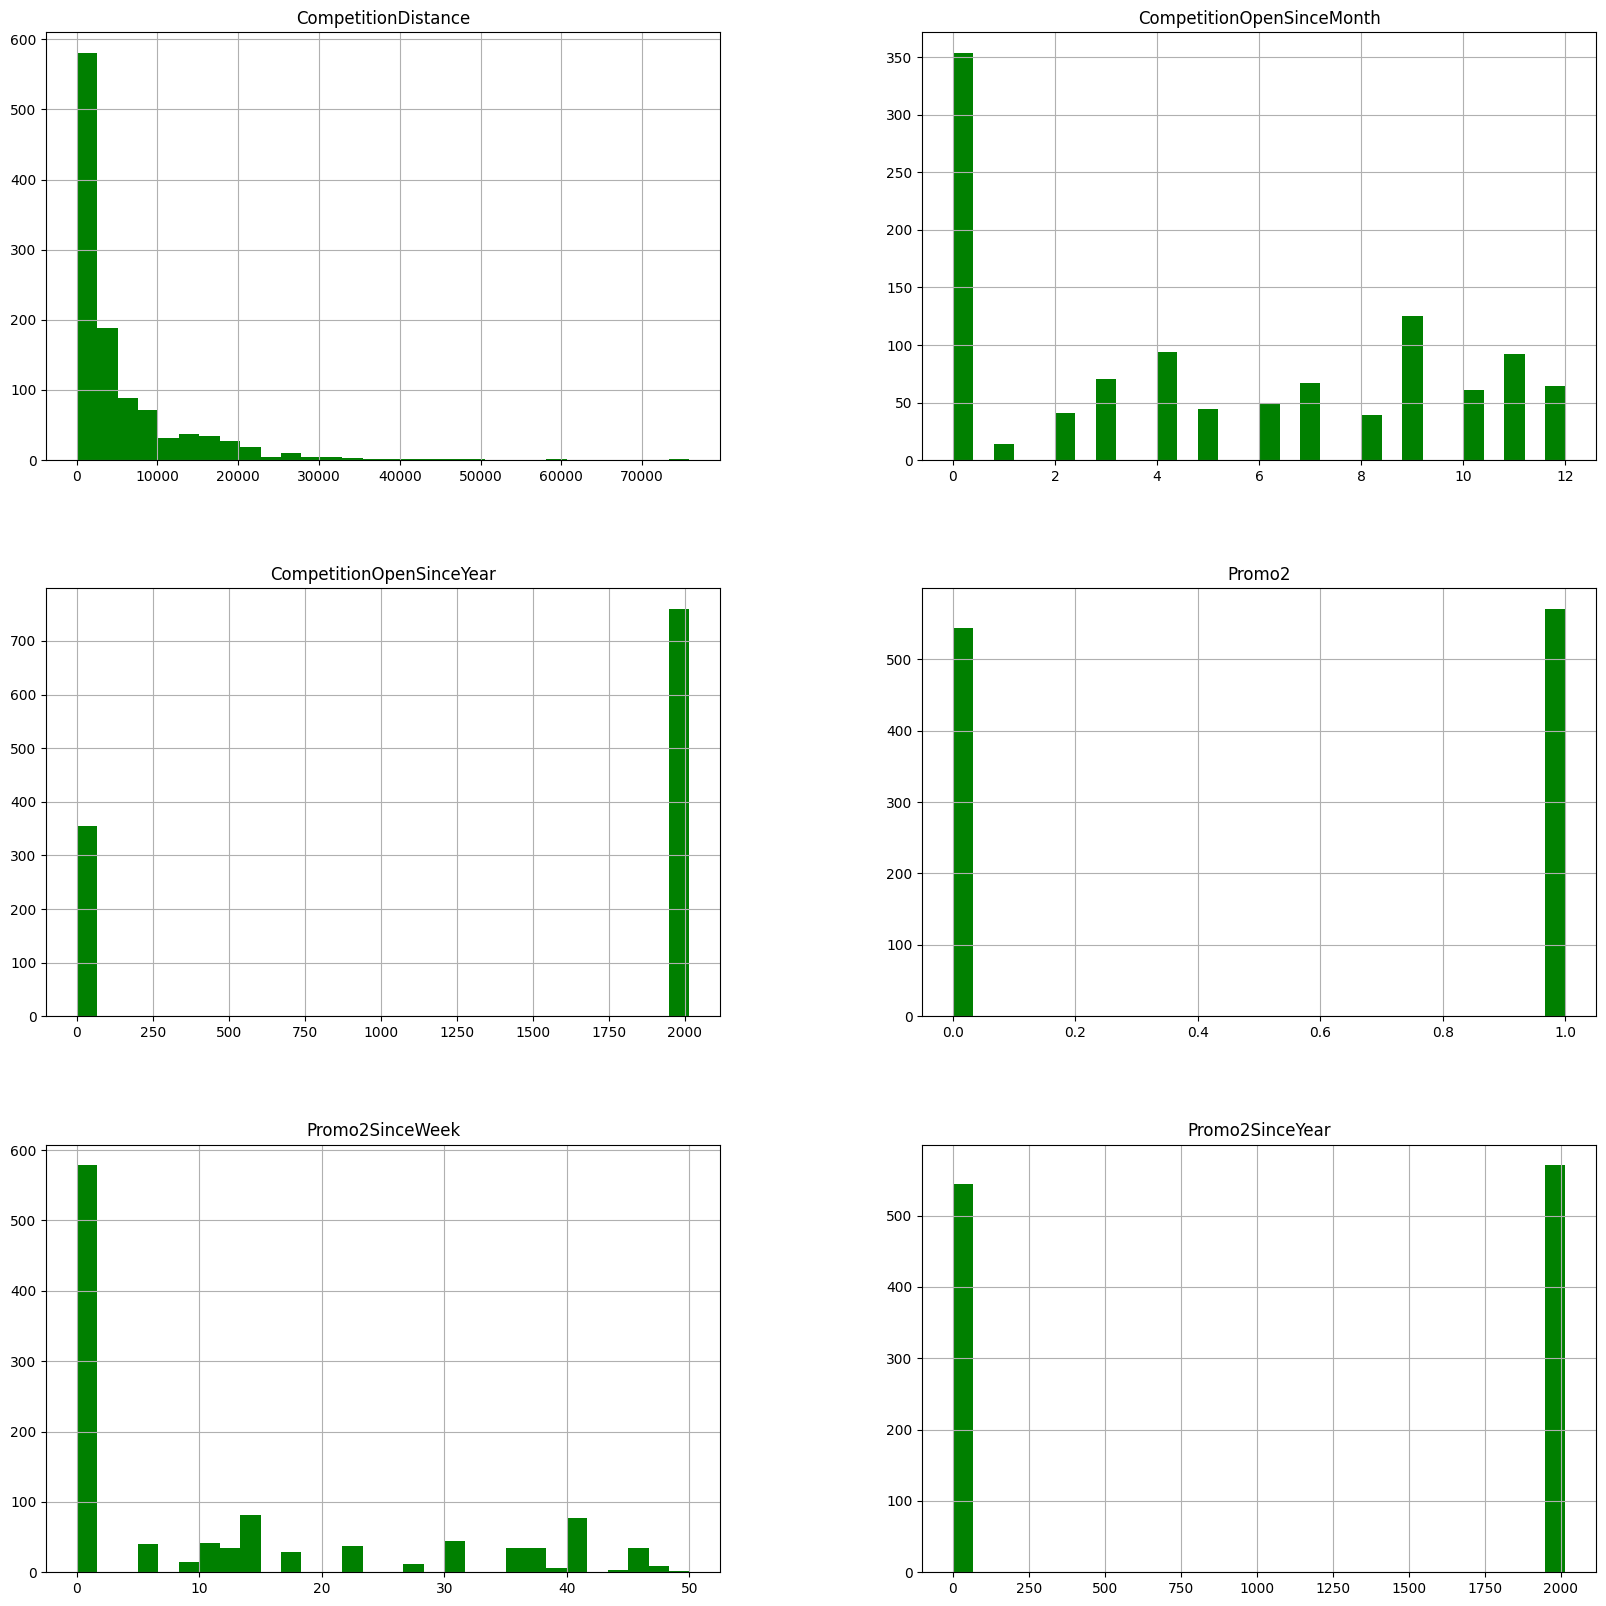

In [74]:
store_data[['StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']].hist(bins = 30, figsize = (20,20), color = 'g')

## NOW we can merge the two dataset with the commom column as STORE

In [44]:
merged_data = pd.merge(sales_data, store_data, how = 'inner', on = 'Store') 

In [45]:
merged_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0


In [46]:
merged_data.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [47]:
merged_data.to_csv('test.csv', index=False)

In [48]:
merged_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec"


In [49]:
correlations = merged_data.corr()['Sales'].sort_values()
correlations

/tmp/ipykernel_926634/1254737517.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = merged_data.corr()['Sales'].sort_values()


DayOfWeek                   -0.46213
Promo2SinceYear             -0.09106
Promo2                      -0.09104
Promo2SinceWeek             -0.04414
CompetitionDistance         -0.01861
CompetitionOpenSinceMonth   -0.01243
CompetitionOpenSinceYear     0.00275
Store                        0.00513
SchoolHoliday                0.08512
Promo                        0.45234
Open                         0.67847
Customers                    0.89471
Sales                        1.00000
Name: Sales, dtype: float64

/tmp/ipykernel_926634/2693912793.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = merged_data.corr()


<AxesSubplot: >

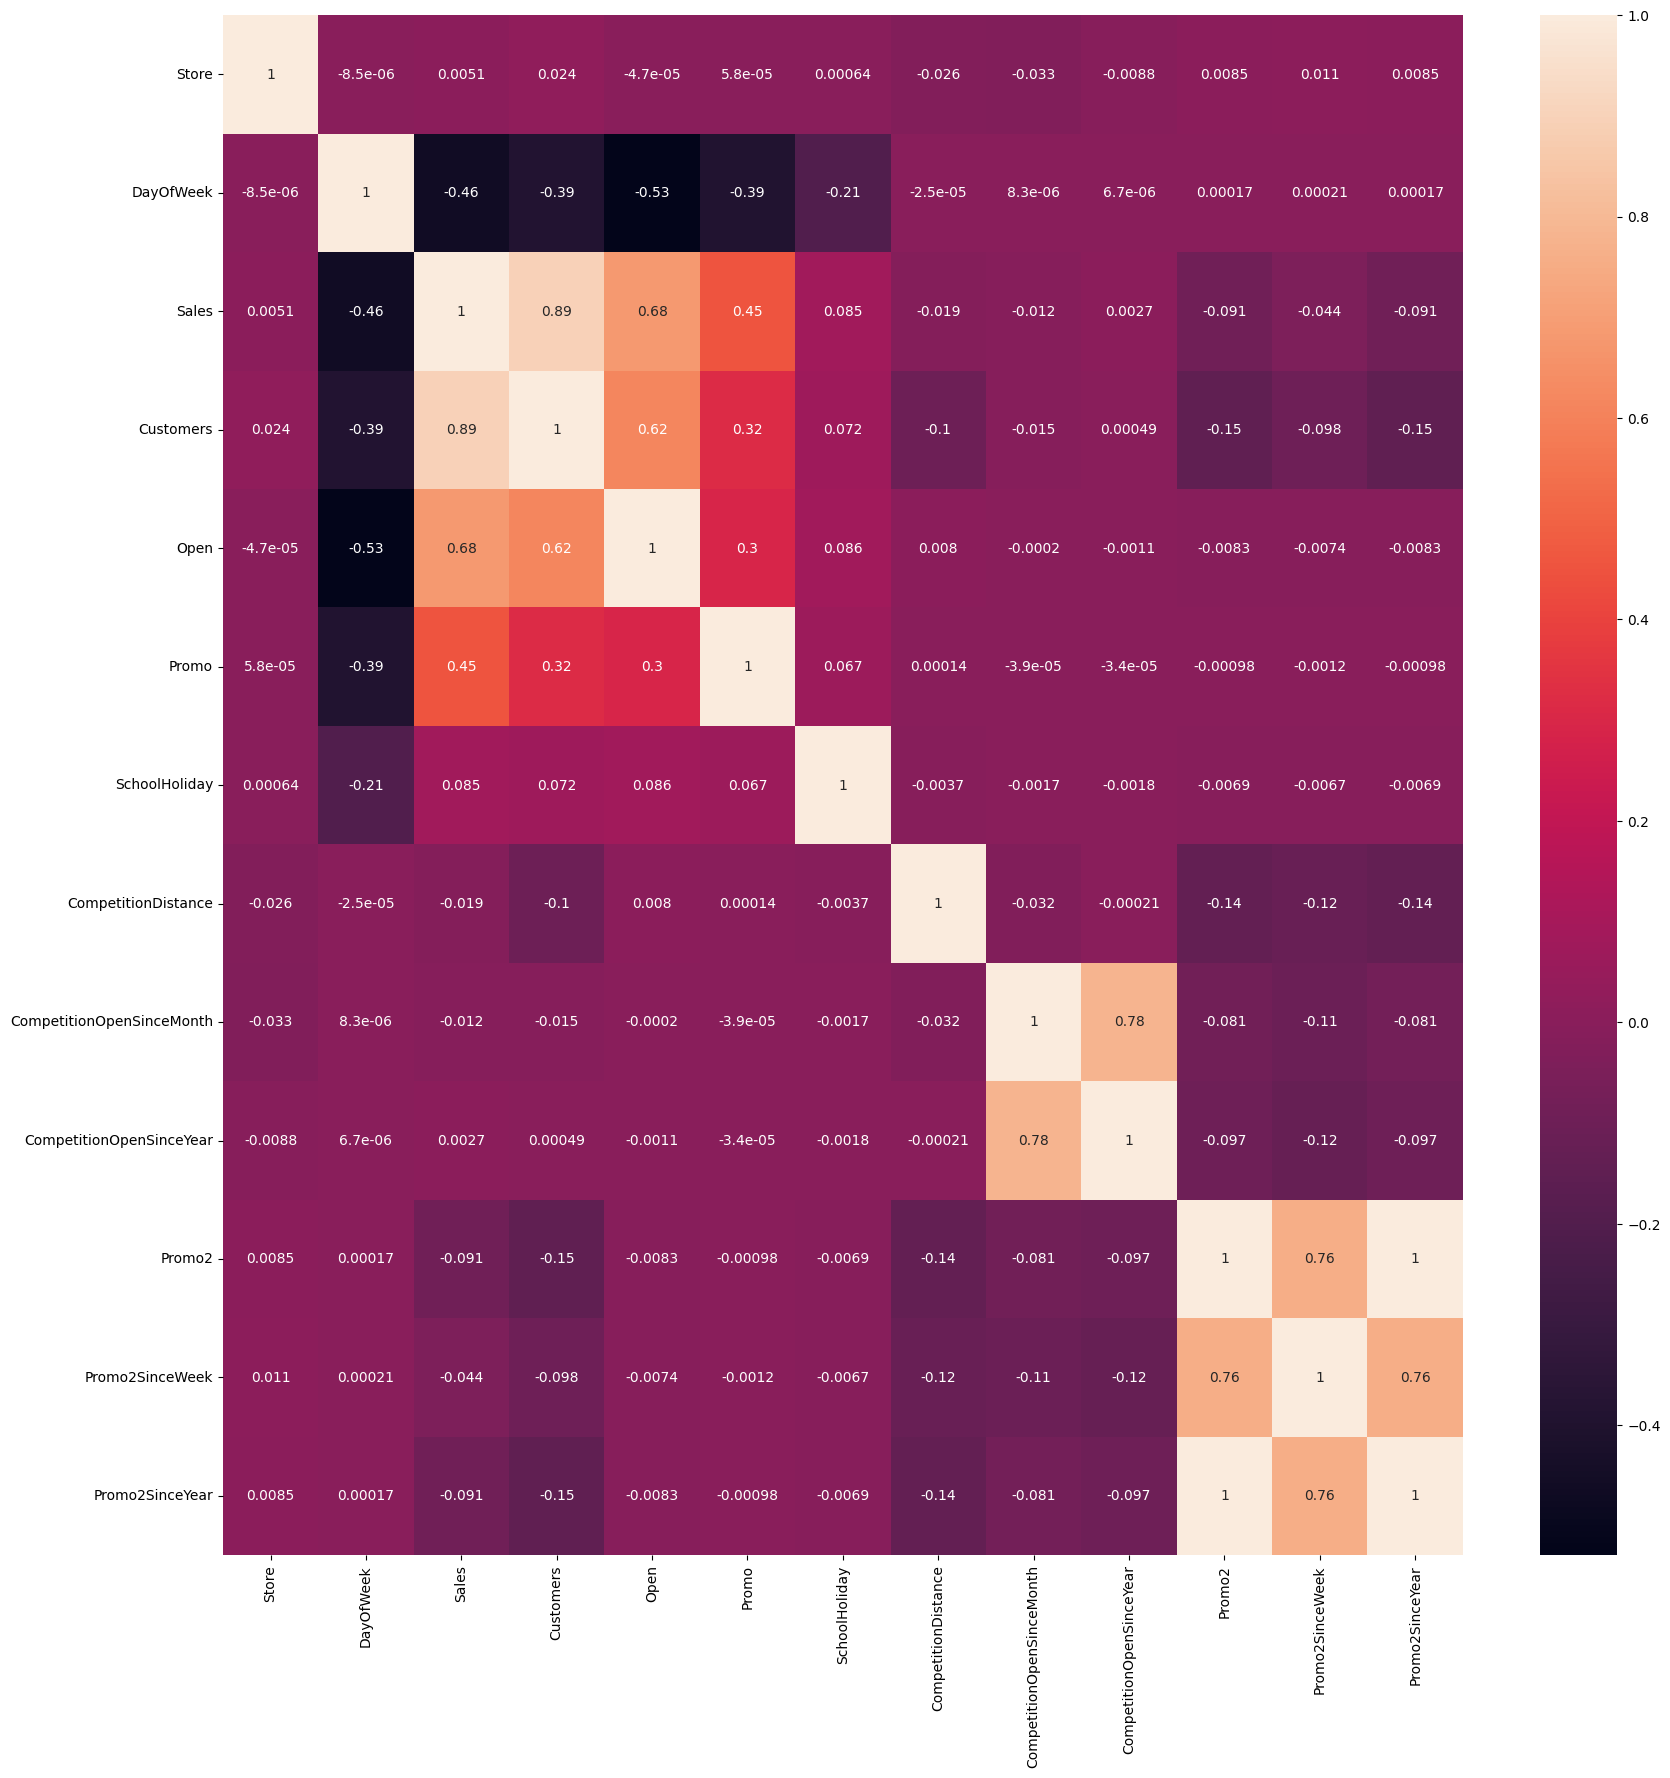

In [50]:
correlations = merged_data.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)

In [51]:
## for forecasting, let us separate the year, month and day
merged_data['Year'] = pd.DatetimeIndex(merged_data['Date']).year
merged_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0,2015
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0,2015
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0,2015
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0,2015
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec",2013
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec",2013
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec",2013
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec",2013


In [52]:
merged_data['Month'] = pd.DatetimeIndex(merged_data['Date']).month
merged_data['Day'] = pd.DatetimeIndex(merged_data['Date']).day

In [53]:
merged_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,1270.00000,9.00000,2008.00000,0,0.00000,0.00000,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,...,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec",2013,1,5
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,...,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec",2013,1,4
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,...,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec",2013,1,3
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,...,5350.00000,0.00000,0.00000,1,22.00000,2012.00000,"Mar,Jun,Sept,Dec",2013,1,2


Text(0.5, 1.0, 'Average Sales Per Month')

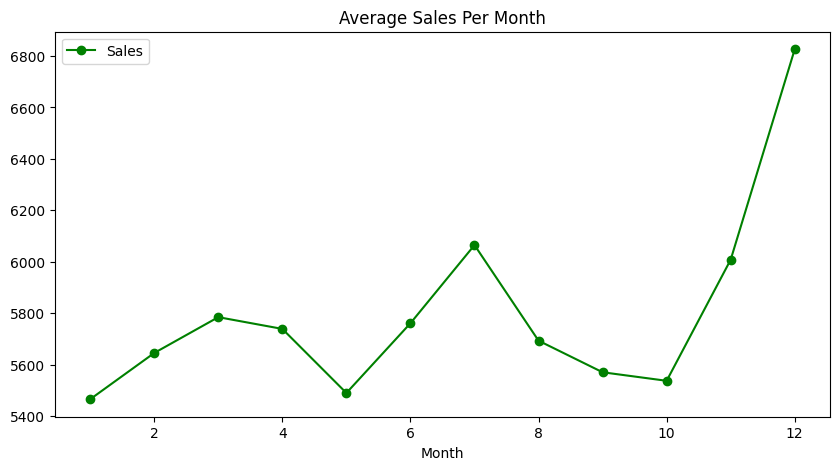

In [54]:
axis = merged_data.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'g')
axis.set_title('Average Sales Per Month')

Text(0.5, 1.0, 'Average Sales Per Year')

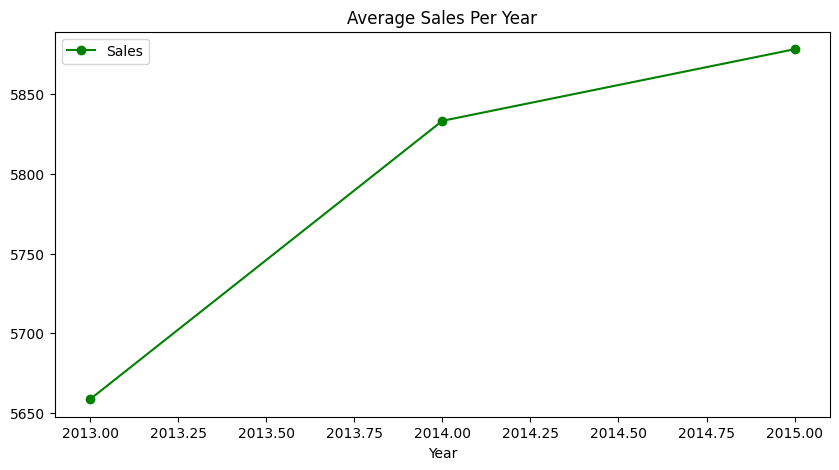

In [60]:
axis = merged_data.groupby('Year')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'g')
axis.set_title('Average Sales Per Year')

- Sales also seems to increase over the year

Text(0.5, 1.0, 'Average Customers Per Month')

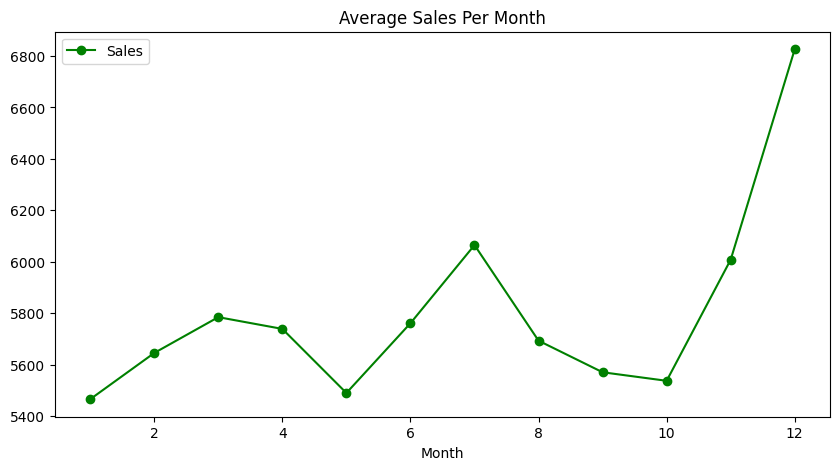

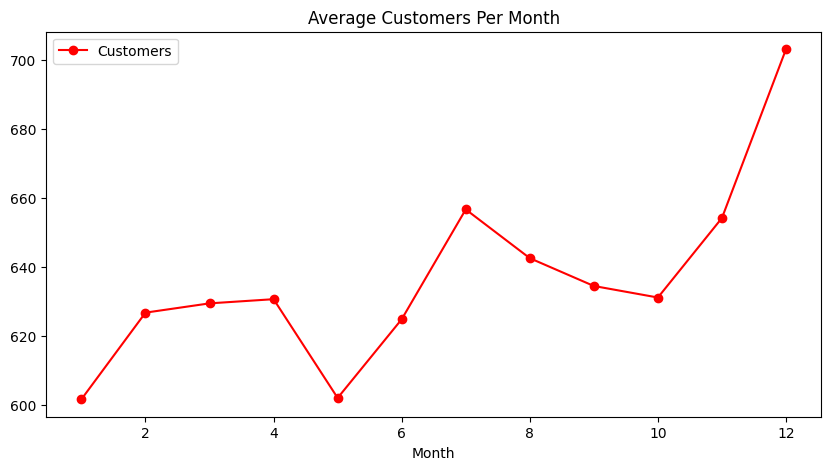

In [59]:
## Lets see the avrage sales and customers per month
axis = merged_data.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'g')
axis.set_title('Average Sales Per Month')

axis = merged_data.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Customers Per Month')

 - It looks like sales and number of customers peak around christmas timeframe

Text(0.5, 1.0, 'Average Customers Per Day')

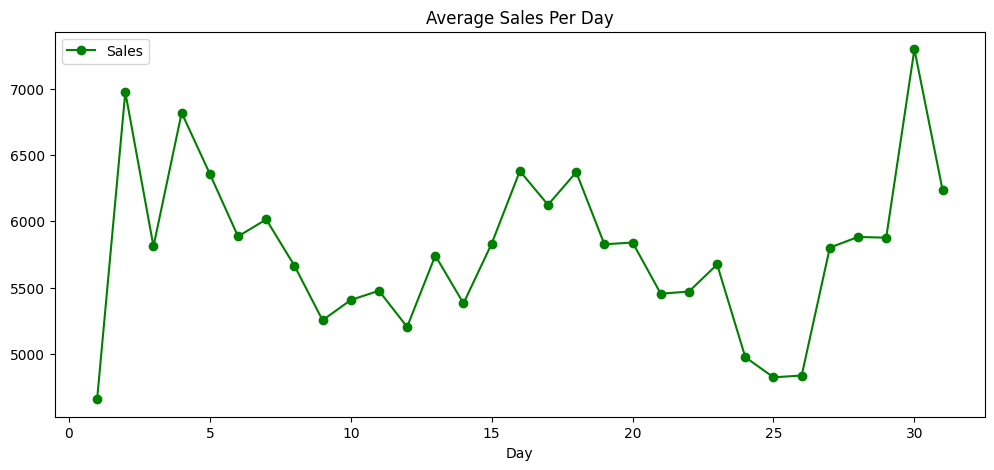

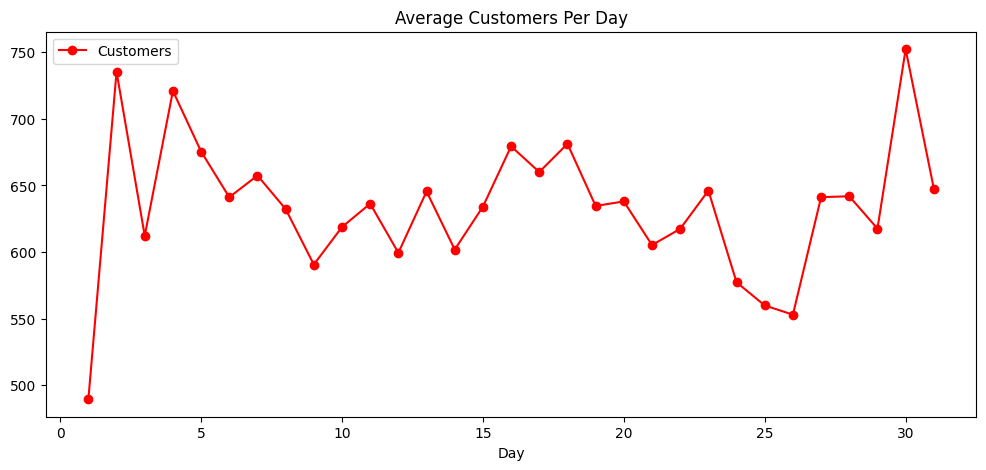

In [63]:
## Lets see the avrage sales and customers per day
axis = merged_data.groupby('Day')[['Sales']].mean().plot(figsize = (12,5), marker = 'o', color = 'g')
axis.set_title('Average Sales Per Day')

axis = merged_data.groupby('Day')[['Customers']].mean().plot(figsize = (12,5), marker = 'o', color = 'r')
axis.set_title('Average Customers Per Day')

 - Minimum number of customers are generally around the 24th of the month 
-  Most customers and sales are around 30th and 1st of the month

Text(0.5, 1.0, 'Average Customers Per Day of the Week')

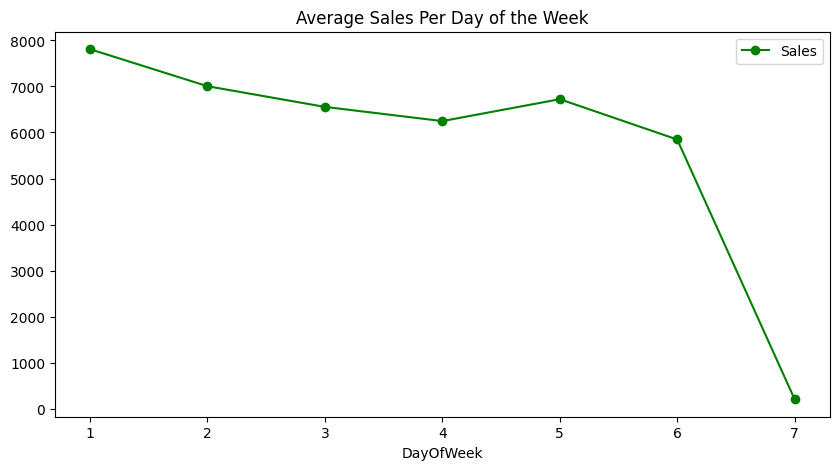

<Figure size 640x480 with 0 Axes>

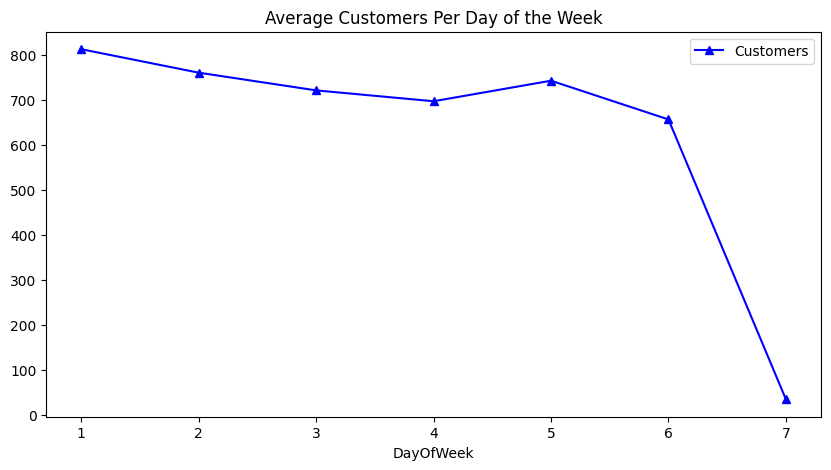

In [65]:
axis = merged_data.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'g')
axis.set_title('Average Sales Per Day of the Week')

plt.figure()
axis = merged_data.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Day of the Week')


<AxesSubplot: xlabel='Promo', ylabel='Customers'>

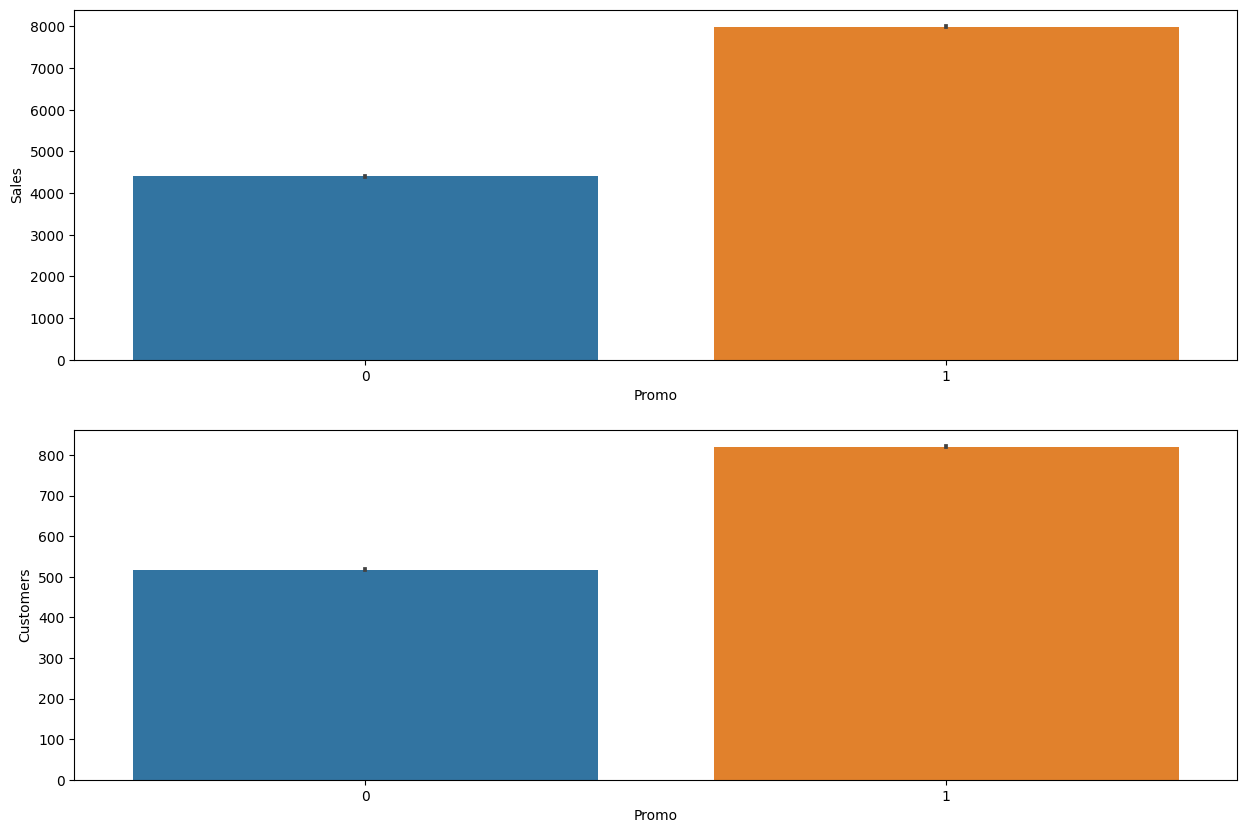

In [67]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.barplot(x = 'Promo', y = 'Sales', data = merged_data)

plt.subplot(212)
sns.barplot(x = 'Promo', y = 'Customers', data = merged_data)

In [68]:
sales_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


<AxesSubplot: xlabel='StateHoliday', ylabel='count'>

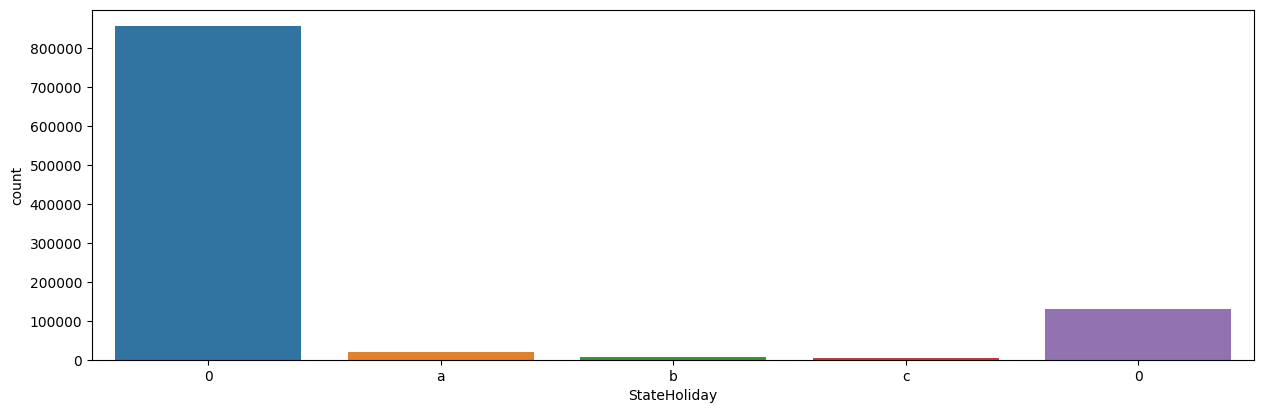

In [88]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.countplot(x = 'StateHoliday', data = merged_data)

## WITH THIS EDA IS DONE

## Time to make some forecast - using fbprophet (like our previous projects) 

In [69]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
def sales_prediction(Store_ID, sales_df, periods, path):

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model    = Prophet()
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods=periods)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure.savefig(os.path.join(path, f"store_{Store_ID}_forecast.png"))
  figure2  = model.plot_components(forecast)
  figure2.savefig(os.path.join(path, f"store_{Store_ID}_components.png"))

In [110]:
school_holidays = merged_data[merged_data['SchoolHoliday'] == 1].loc[:, 'Date'].values
school_holidays.shape

(181721,)

In [111]:
state_holidays = merged_data [ (merged_data['StateHoliday'] == 'a') | (merged_data['StateHoliday'] == 'b') | (merged_data['StateHoliday'] == 'c')  ].loc[:, 'Date'].values
state_holidays.shape

(31050,)

In [112]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})

In [113]:
state_holidays

,ds,holiday
0,2015-06-04,state_holiday
1,2015-05-25,state_holiday
2,2015-05-14,state_holiday
3,2015-05-01,state_holiday
4,2015-04-06,state_holiday
...,...,...
31045,2013-05-09,state_holiday
31046,2013-05-01,state_holiday
31047,2013-04-01,state_holiday
31048,2013-03-29,state_holiday


In [114]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                                'holiday': 'school_holiday'})
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
181716,2013-01-05,school_holiday
181717,2013-01-04,school_holiday
181718,2013-01-03,school_holiday
181719,2013-01-02,school_holiday


In [115]:
school_state_holidays = pd.concat((state_holidays, school_holidays))
school_state_holidays

,ds,holiday
0,2015-06-04,state_holiday
1,2015-05-25,state_holiday
2,2015-05-14,state_holiday
3,2015-05-01,state_holiday
4,2015-04-06,state_holiday
...,...,...
181716,2013-01-05,school_holiday
181717,2013-01-04,school_holiday
181718,2013-01-03,school_holiday
181719,2013-01-02,school_holiday



- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -52.9352
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       1495.78    0.00202186       195.565   1.693e-05       0.001      146  LS failed, Hessian reset 
      99       1496.19   0.000605085       95.2194      0.6889      0.6889      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       1497.25   4.56203e-05       102.173   4.591e-07       0.001      265  LS failed, Hessian reset 
     199       1497.26   1.92669e-07       92.1762           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       1497.26   2.96153e-08       94.4878      0.1839      0.8952      328   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


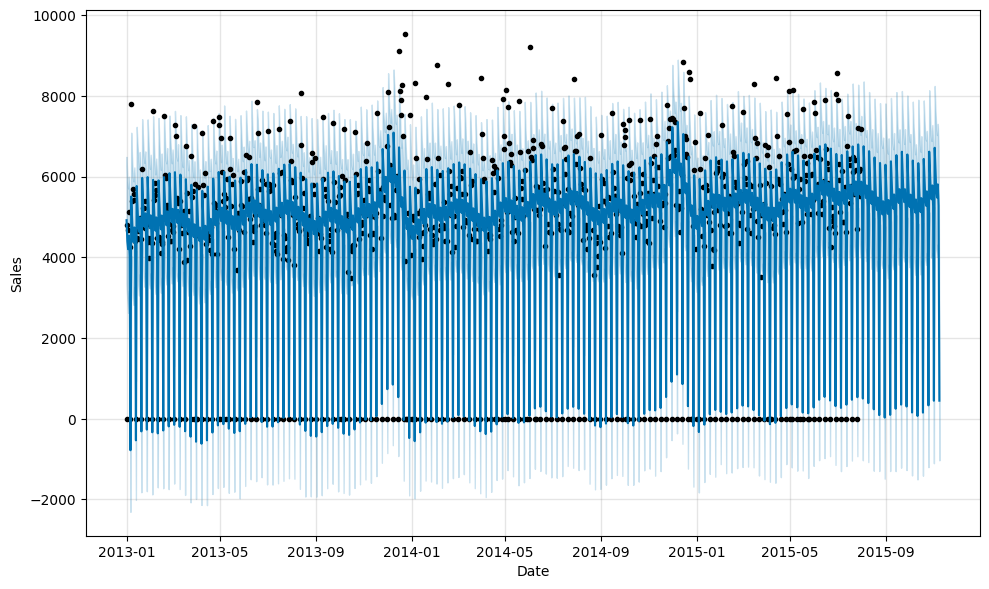

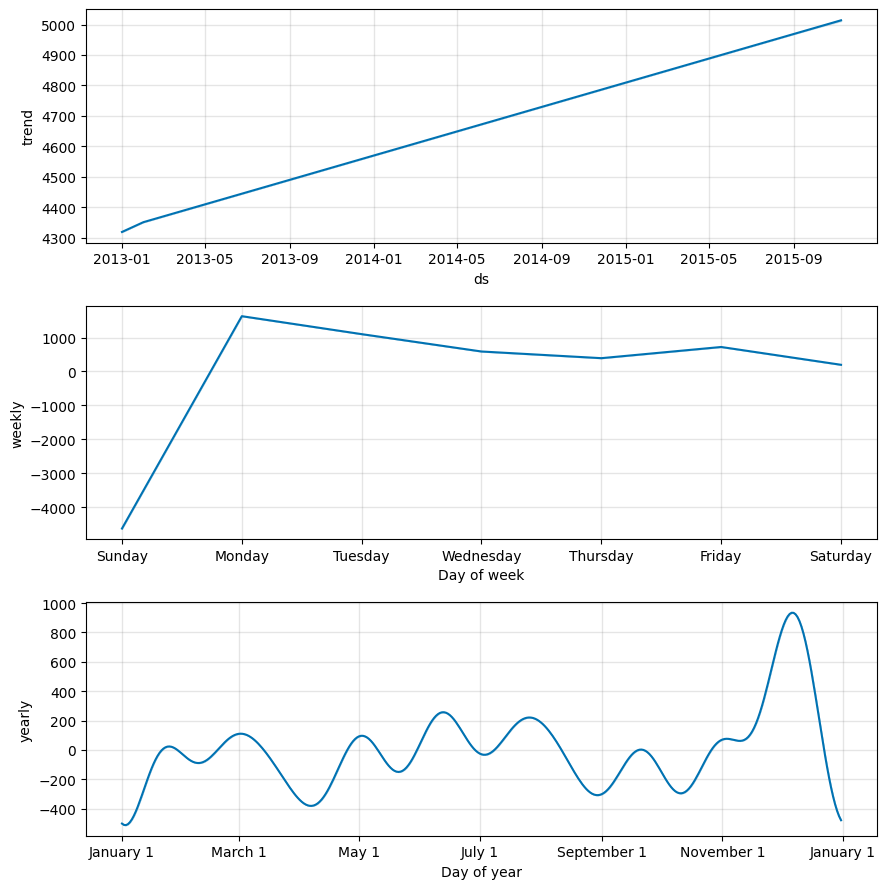

In [108]:
sales_prediction(10, merged_data, 100, '.')

In [117]:
def sales_prediction_holiday(Store_ID, sales_df, holidays, periods, path):
  # Function that takes in the storeID and returns two date/sales columns in Prophet format
  # Format data to fit prophet 

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model    = Prophet(holidays = holidays)
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure.savefig(os.path.join(path, f"store_{Store_ID}_forecast_holiday.png"))
  figure2  = model.plot_components(forecast)
  figure2.savefig(os.path.join(path, f"store_{Store_ID}_components_holiday.png"))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -53.4589
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       1709.29    0.00455832         249.2     5.3e-05       0.001      134  LS failed, Hessian reset 
      99       1709.71    0.00118435       67.6355       0.649       0.649      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174        1712.1    0.00077275       126.988   7.387e-06       0.001      289  LS failed, Hessian reset 
     199       1712.27   4.87131e-05       88.7102       0.354       0.354      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       1712.54   0.000114214       86.4047   1.183e-06       0.001      444  LS failed, Hessian reset 
     299       1712.55    8.1642e-06       89.8151       0.364      0.9796      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

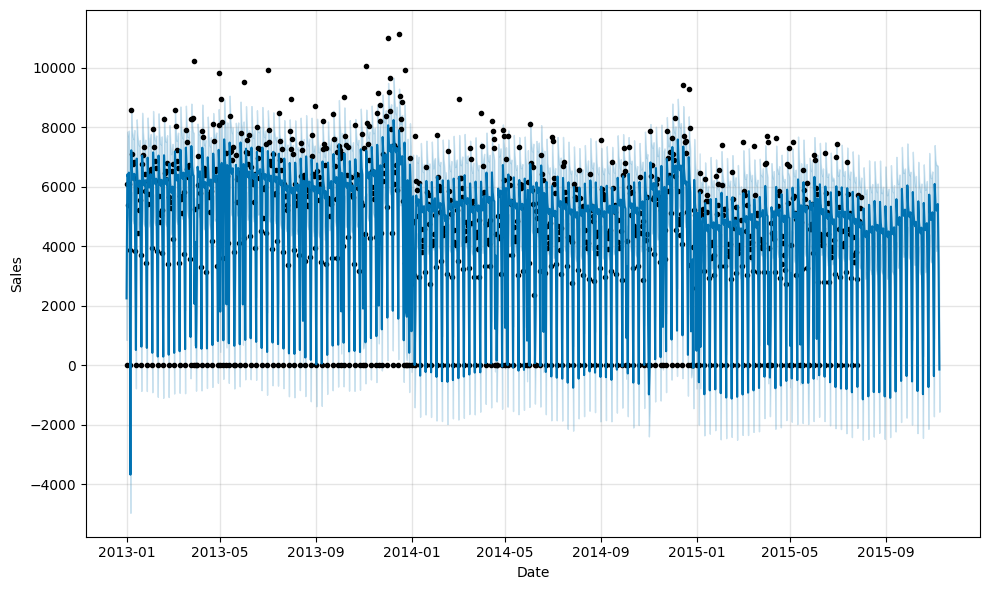

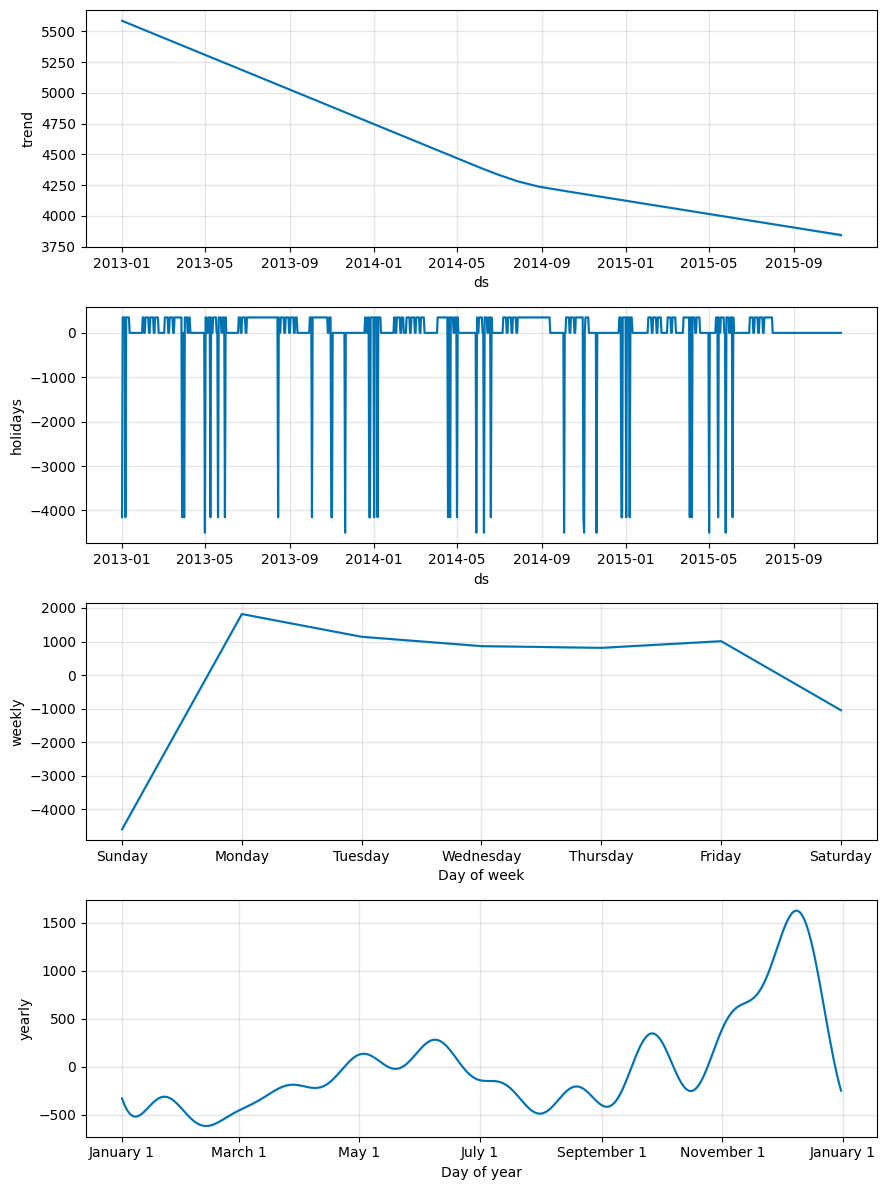

In [118]:
sales_prediction_holiday(6, merged_data, school_state_holidays, 100, '.')